In [25]:
# import libraries
import os
import numpy as np
import pandas as pd
import random
import pickle5 as pickle

import matplotlib.pyplot as plt
%matplotlib inline

from eda import *

In [2]:
# load data
with open('../WM-clean.pkl', "rb") as fh:
    raw_data = pickle.load(fh)
print(f'Raw data shape: {raw_data.shape}')

# remove test set
data = raw_data[raw_data.dataset != 'test'].reset_index(drop=True)
print(f'Train/dev data shape: {data.shape}')
#data.head()

Raw data shape: (172950, 11)
Train/dev data shape: (147007, 11)


In [3]:
# calculate density of dies in wafer map
# as represented by nonzero elements
def wafer_density(row, col, x, y):
    nonzeros = np.count_nonzero(row[col])
    pixels = row[x] * row[y]
    return nonzeros/pixels

data['density'] = data.apply (lambda row: wafer_density(row, 'waferMap', 'x_', 'y_'), axis=1)

# create a dictionary of the max density for each lot
# assume that this represents the full uncorrupted wafer map
lot_density = data.groupby('lotName').density.max().to_dict()

# find corrupted maps by comparing to dictionary value
# define corrupted as missing nonzero values or missing density
def find_corrupted(row, lot, density, dictionary):
    if row[density] == dictionary[row[lot]]:
        return 0
    else:
        return 1

data['is_corrupted'] = data.apply (lambda row: find_corrupted(row, 'lotName', 'density', lot_density), axis=1)

# what percentage of density is missing, if any?
def missing_density(row, lot, density, dictionary):
    missing_pct = (dictionary[row[lot]] - row[density]) / dictionary[row[lot]]
    return missing_pct

data['missing_density'] = data.apply (lambda row: missing_density(row, 'lotName', 'density', lot_density), axis=1)

data.head()

,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset,density,is_corrupted,missing_density
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0.779167,0,0.0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0.779167,0,0.0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0.779167,0,0.0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,7.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0.779167,0,0.0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,8.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0.779167,0,0.0


In [4]:
# how many wafer maps are corrupted
data[['waferMap', 'is_corrupted']].groupby('is_corrupted').count()

,waferMap
is_corrupted,
0,136141
1,10866


In [5]:
# create dataframe with just corrupted maps
corrupted = data[data.missing_density > 0]

# sanity check - how many corrupted maps are there?
print(f'Number of corrupted maps: {len(corrupted)}')

# how many lots contain corrupted maps?
corrupted_lots = corrupted.lotName.unique()
print(f'Lots that have at least one corrupted map: {len(corrupted_lots)}')

Number of corrupted maps: 10866
Lots that have at least one corrupted map: 1126


<AxesSubplot:>

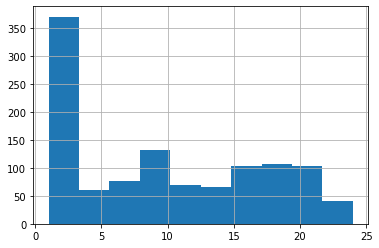

In [37]:
# distribution of corrupted maps by lot
corrupted.groupby('lotName').size().hist()

In [41]:
corrupted.groupby('lotName').size().head(10)

lotName
lot11982    1
lot1288     2
lot13703    6
lot1414     1
lot1417     1
lot1419     5
lot14235    1
lot15094    1
lot15292    2
lot15300    1
dtype: int64

lot45201


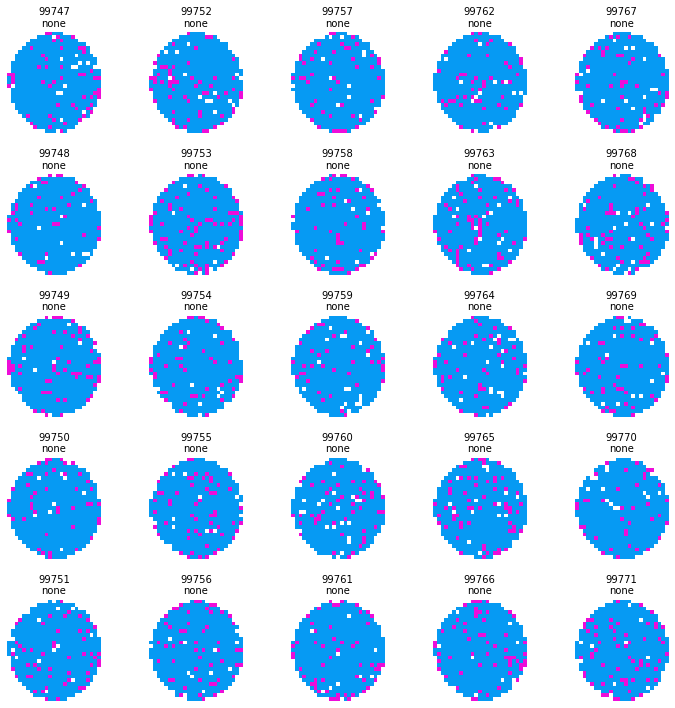

In [36]:
plot_lot(data, 'lot45201')

lot1417


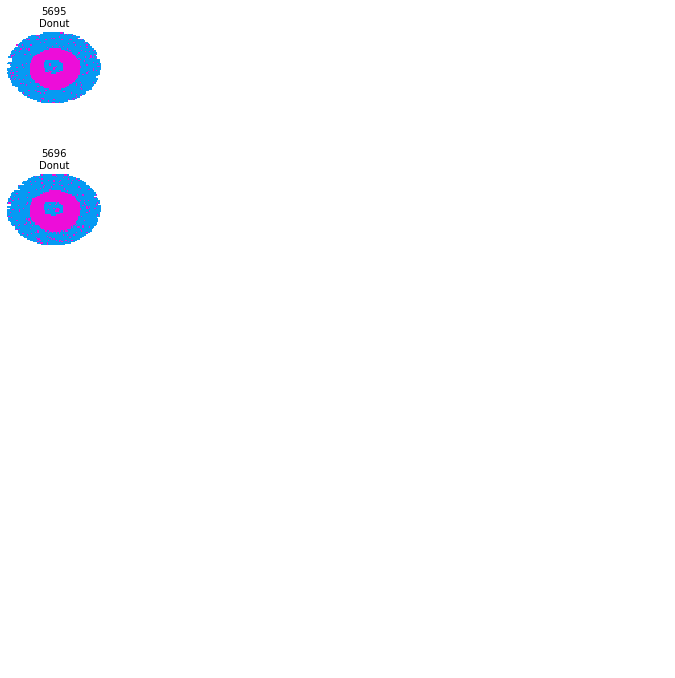

In [47]:
plot_lot(data, 'lot1417')

<AxesSubplot:>

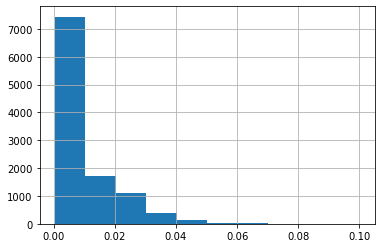

In [19]:
# distribution of missing density (less than 10%)
corrupted[corrupted.missing_density < 0.1]['missing_density'].hist()

<AxesSubplot:>

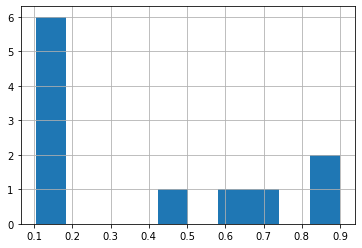

In [22]:
# distribution of missing density (greater than 5%)
corrupted[corrupted.missing_density >= 0.1]['missing_density'].hist()

Number of maps with >10% missing density: 11


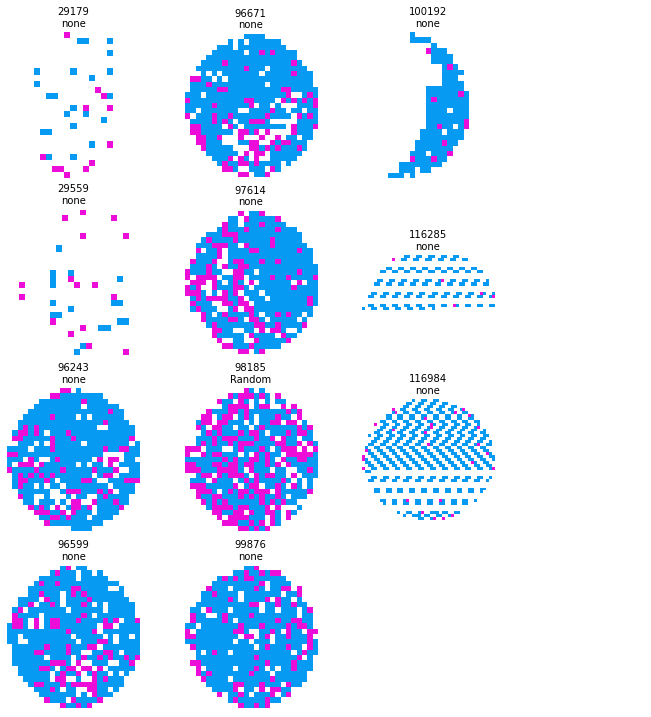

In [23]:
most_corrupted = data.index[data['missing_density'] >= 0.1].tolist()
print(f'Number of maps with >10% missing density: {len(most_corrupted)}')
plot_list(data, most_corrupted)

Number of maps with <10% missing density: 146996


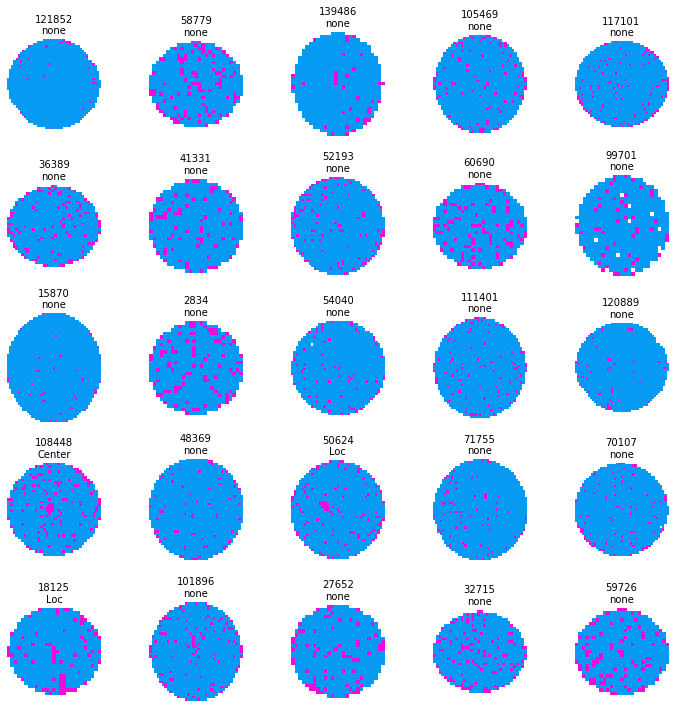

In [33]:
less_corrupted = data.index[data['missing_density'] < 0.1].tolist()
print(f'Number of maps with <10% missing density: {len(less_corrupted)}')

random.seed(424)
random_corrupted = random.sample(less_corrupted, 25)

plot_list(data, random_corrupted)